In [206]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [207]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [208]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [246]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        n, m = X.shape
        self.is_leaf = False
        
        if self.depth >= self.max_depth or n <= self.min_sample or self.check_impurity(y):
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        self.split_id, self.split_value, loss = self.compute_split_point(X, y)
        
        X_left, y_left = self.get_left_region(X, y)
        X_right, y_right = self.get_right_region(X, y)
        
        print ("X[", self.split_id, "] < ", self.split_value)
        print ("entropy: ", self.split_loss_function(y)," loss:", loss)
        print ("value: [", len(y_left), len(y_right), "]")
        self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                                  self.depth + 1, self.min_sample, self.max_depth)
        self.left.fit(X_left, y_left)
        
        self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator,
                                   self.depth + 1, self.min_sample, self.max_depth)
        self.right.fit(X_right, y_right)
        
        return self

    def check_impurity(self, y):
        unique, counts = np.unique(y, return_counts=True)
        if len(unique) > 1:
            return False
        else:
            return True
        
    def get_left_region(self, X, y):
        n, m = X.shape
        indexes = []
        for j in range(0, n):
            if X[j][self.split_id] <= self.split_value:
                indexes.append(j)
        
        return X[indexes, :], y[indexes]
    
    def get_right_region(self, X, y):
        n, m = X.shape
        indexes = []
        for j in range(0, n):
            if X[j][self.split_id] > self.split_value:
                indexes.append(j)
        
        return X[indexes, :], y[indexes]
    
    def split_y(self, index, value, X, y):
        n, m = X.shape
        y_id_l = []
        y_id_r = []
        for i in range(0, n):
            if X[i][index] > value:
                y_id_r.append(i)
            else:
                y_id_l.append(i)

        return y[y_id_l], y[y_id_r]
    
    def compute_split_point(self, X, y):
        n, m = X.shape
        min_loss = 99999999
        split_index = 0
        split_value = 0
        
        for j in range(0, m):
            column = X[:,j]
            col = np.unique(column)
            col = np.sort(col)
            col.reshape(-1)
            print (".................... ", j)
            for i in range(0, len(col)):
                if i == 0:
                    continue
                v = col[i - 1] + (col[i] - col[i - 1]) / 2
                y_l, y_r = self.split_y(j, v, X, y)
                l_l = self.split_loss_function(y_l)
                l_r = self.split_loss_function(y_r)
                print ("value: ", v, "lost: ", l_l, " + ", l_r)
                if min_loss >= (l_l + l_r):
                    min_loss = l_l + l_r
                    split_index = j
                    split_value = v
        return split_index, split_value, min_loss
    
    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [247]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    unique, counts = np.unique(label_array, return_counts=True)
    a = counts/np.sum(counts)
    entropy = -np.sum(a * np.log2(a))
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    unique, counts = np.unique(label_array, return_counts=True)
    a = counts/np.sum(counts)
    gini = np.sum(a * (1 - a))
    return gini

In [248]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [249]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

In [250]:
clf1 = Classification_Tree(max_depth=10)
clf1.fit(x_train, y_train_label)

....................  0
value:  -4.807932769013439 lost:  -0.0  +  0.7970401196757976
value:  -4.419616295299514 lost:  -0.0  +  0.7990485210442682
value:  -4.225137685602128 lost:  -0.0  +  0.8010654763930383
value:  -4.143768976176519 lost:  -0.0  +  0.8030909760146978
value:  -4.061970959125559 lost:  -0.0  +  0.8051250074646821
value:  -3.9672080436551367 lost:  -0.0  +  0.8071675554288905
value:  -3.8541882026959278 lost:  -0.0  +  0.8092186015852773
value:  -3.7417406486350906 lost:  -0.0  +  0.8112781244591328
value:  -3.672380520760584 lost:  -0.0  +  0.8133460992717425
value:  -3.6417906939629243 lost:  -0.0  +  0.8154224977821039
value:  -3.6041722889859544 lost:  -0.0  +  0.8175072881213616
value:  -3.580305037510447 lost:  -0.0  +  0.8196004346196012
value:  -3.516089530270833 lost:  -0.0  +  0.8217018976246258
value:  -3.443500375371321 lost:  -0.0  +  0.8238116333123173
value:  -3.3823775000789986 lost:  -0.0  +  0.8259295934881626
value:  -3.3050157062207504 lost:  -0.0 

value:  0.9877185590750885 lost:  0.8351164948421137  +  0.710676853856123
value:  1.0801932166000106 lost:  0.843349289138202  +  0.6868088934028035
value:  1.1700019536259618 lost:  0.8512243352621378  +  0.6609623351442084
value:  1.203205460627026 lost:  0.8587579130949384  +  0.6329208984823799
value:  1.2230778514811498 lost:  0.855863382087914  +  0.6385146263620961
value:  1.2370925646129367 lost:  0.863120568566631  +  0.6079696120060725
value:  1.250772211330892 lost:  0.8602858652332408  +  0.6136190195993708
value:  1.2786824276801962 lost:  0.8672816222000259  +  0.5801954953637369
value:  1.310637015260222 lost:  0.8739810481273578  +  0.5435644431995964
value:  1.3712621150238677 lost:  0.8803968110001441  +  0.5032583347756457
value:  1.4191665492003227 lost:  0.8865408928220899  +  0.4586858162005403
value:  1.4264973295521473 lost:  0.8924246373175992  +  0.40907313904382653
value:  1.4395945534188725 lost:  0.8898478016282407  +  0.41381685030363374
value:  1.4583732

value:  -2.5580136215305753 lost:  0.31599713297842463  +  0.8561146277685723
value:  -2.500230419438607 lost:  0.3095434291503252  +  0.8584427421459185
value:  -2.4710162334796113 lost:  0.30337483608641397  +  0.8607781176165942
value:  -2.4243638637091594 lost:  0.2974722489192896  +  0.863120568566631
value:  -2.393129372187311 lost:  0.29181825659888583  +  0.8654698974285928
value:  -2.3673182624299054 lost:  0.28639695711595625  +  0.8678258940797088
value:  -2.3477663323574403 lost:  0.2811937964320427  +  0.8701883352082784
value:  -2.322690483437772 lost:  0.2761954276479391  +  0.8725569836465037
value:  -2.2800854477771395 lost:  0.27138958750811115  +  0.8749315876677922
value:  -2.253908047303809 lost:  0.26676498780302604  +  0.8773118802464468
value:  -2.2262131984797886 lost:  0.2623112196143366  +  0.8796975782775169
value:  -2.191900954964791 lost:  0.34781691357106326  +  0.8739810481273578
value:  -2.1786276623202174 lost:  0.3424637724817959  +  0.876412007655703

value:  0.483042649848488 lost:  0.8739810481273578  +  0.6451006442088482
value:  0.5280862551779462 lost:  0.8812908992306927  +  0.6193821946787638
value:  0.6254963574848709 lost:  0.888248046847429  +  0.5916727785823275
value:  0.7468510635091181 lost:  0.8852618941204617  +  0.596510991708588
value:  0.7882320013486702 lost:  0.8822824449111784  +  0.6014353864290772
value:  0.7982225912750989 lost:  0.8890349038123859  +  0.5713549744279549
value:  0.8056420583681421 lost:  0.8861256474645222  +  0.5762914612174369
value:  0.8095347875910097 lost:  0.8926230133850986  +  0.5435644431995964
value:  0.8151870630446192 lost:  0.8897817814516159  +  0.548486608843174
value:  0.8271793699820589 lost:  0.8869456102215852  +  0.5535072654547253
value:  0.8398495754096182 lost:  0.8841151220488477  +  0.5586293734521992
value:  0.8666596194755172 lost:  0.8812908992306927  +  0.5638560041131417
value:  0.9057869097154387 lost:  0.8877250163956498  +  0.52764232609436
value:  0.94164970

value:  -2.1098505834025056 lost:  0.14854949043034824  +  0.8969838216377446
value:  -2.074228652321458 lost:  0.1460942501201363  +  0.8993493197242991
value:  -2.04357101311931 lost:  0.14372616993938178  +  0.9017166373398942
value:  -1.9949730650538542 lost:  0.14144054254182067  +  0.9040853039770349
value:  -1.934827673718598 lost:  0.13923299905509887  +  0.9064548231489875
value:  -1.8941740401051326 lost:  0.1370994788998177  +  0.908824671034663
value:  -1.8616606665013777 lost:  0.13503620280212764  +  0.9111942950464766
value:  -1.8445269768631811 lost:  0.228538143953528  +  0.9061972411785715
value:  -1.787242702821344 lost:  0.225363639127395  +  0.9086185980409245
value:  -1.719615879596784 lost:  0.22228483068568797  +  0.9110397724692714
value:  -1.6790273309914348 lost:  0.2192973081321754  +  0.9134601452569628
value:  -1.614899378720296 lost:  0.29367630985136955  +  0.9084033648635559
value:  -1.5779031244548154 lost:  0.3576467062456332  +  0.9031161721568719
va

value:  3.7129144489991743 lost:  0.8197789593480937  +  0.39124356362925566
value:  3.7725314416360836 lost:  0.8176406439528727  +  0.41381685030363374
value:  3.8283425770094395 lost:  0.8238116333123173  +  -0.0
value:  3.8569706632060408 lost:  0.8217018976246258  +  -0.0
value:  3.8775430102376607 lost:  0.8196004346196012  +  -0.0
value:  3.909438391773258 lost:  0.8175072881213616  +  -0.0
value:  3.956187360506143 lost:  0.8154224977821039  +  -0.0
value:  3.983669613762058 lost:  0.8133460992717425  +  -0.0
value:  4.040951473519375 lost:  0.8112781244591328  +  -0.0
value:  4.0955600941118915 lost:  0.8092186015852773  +  -0.0
value:  4.1423161473494154 lost:  0.8071675554288905  +  -0.0
value:  4.1819738844853465 lost:  0.8051250074646821  +  -0.0
value:  4.192433905686198 lost:  0.8030909760146978  +  -0.0
X[ 1 ] <  4.192433905686198
entropy:  0.8010654763930383  loss: 0.8030909760146978
value: [ 196 1 ]
....................  0
value:  -4.419616295299514 lost:  -0.0  +  0.

value:  0.7635277644612672 lost:  0.8238116333123173  +  0.7642045065086203
value:  0.788386736326306 lost:  0.8206501291977117  +  0.7698205808588191
value:  0.8571371061263743 lost:  0.8296071030882032  +  0.74959525725948
value:  0.9396278008214511 lost:  0.8265086395554189  +  0.7553754125614287
value:  0.9877185590750885 lost:  0.8351164948421137  +  0.7335379291086666
value:  1.0801932166000106 lost:  0.843349289138202  +  0.709825885194168
value:  1.1700019536259618 lost:  0.8512243352621378  +  0.6840384356390417
value:  1.203205460627026 lost:  0.8587579130949384  +  0.6559420757694149
value:  1.2230778514811498 lost:  0.855863382087914  +  0.6619760641115652
value:  1.2370925646129367 lost:  0.863120568566631  +  0.631263018091612
value:  1.250772211330892 lost:  0.8602858652332408  +  0.6373874992221911
value:  1.2786824276801962 lost:  0.8672816222000259  +  0.6036522497544011
value:  1.310637015260222 lost:  0.8739810481273578  +  0.5665095065529053
value:  1.3712621150238

value:  -1.9732892504556705 lost:  0.3138129641688651  +  0.9009799714273107
value:  -1.901476179602671 lost:  0.3095434291503252  +  0.9034535552068337
value:  -1.8925666635343616 lost:  0.30540057087920036  +  0.9059282160429991
value:  -1.8358280178817128 lost:  0.3013786435930858  +  0.9084033648635559
value:  -1.7432868922728462 lost:  0.2974722489192896  +  0.9108783787500366
value:  -1.6962066086987098 lost:  0.29367630985136955  +  0.9133525990767272
value:  -1.689381731885163 lost:  0.28998604703320907  +  0.9158253295377164
value:  -1.683068079448634 lost:  0.28639695711595625  +  0.9182958340544896
value:  -1.6779606657030484 lost:  0.2829047929798921  +  0.9207633345559458
value:  -1.6694224761050072 lost:  0.345117314944953  +  0.9157691529744942
value:  -1.6582283850681396 lost:  0.3411538931451762  +  0.9182958340544896
value:  -1.648134612112809 lost:  0.3372900666170139  +  0.9208193728437064
value:  -1.5762393086095563 lost:  0.39124356362925566  +  0.915710362328227


value:  2.789490269156702 lost:  0.843859751394884  +  0.2761954276479391
value:  2.872279368962909 lost:  0.8416295231538202  +  0.28639695711595625
value:  2.919532144386112 lost:  0.8394072488103348  +  0.2974722489192896
value:  2.97804257697005 lost:  0.8371930278506567  +  0.3095434291503252
value:  3.033559742572698 lost:  0.8349869527804661  +  0.3227569588973982
value:  3.0959911485007217 lost:  0.8327891094481115  +  0.3372900666170139
value:  3.1382022103208564 lost:  0.8388067647725164  +  -0.0
value:  3.174022559587174 lost:  0.8366407419411673  +  -0.0
value:  3.2511872697255724 lost:  0.8344825503082125  +  -0.0
value:  3.324852276118376 lost:  0.8323322690121193  +  -0.0
value:  3.3732034290886657 lost:  0.8301899714180443  +  -0.0
value:  3.423976135646645 lost:  0.828055725379504  +  -0.0
value:  3.4839216715354007 lost:  0.8259295934881626  +  -0.0
value:  3.640544329606966 lost:  0.8238116333123173  +  -0.0
value:  3.7626342055509654 lost:  0.8217018976246258  +  -0

value:  -1.391798605635003 lost:  0.3955378064564774  +  0.9182958340544896
value:  -1.3750869127152594 lost:  0.39124356362925566  +  0.9208780154383214
value:  -1.348304587665805 lost:  0.38705142139219784  +  0.9234559626335352
value:  -1.3273614489526457 lost:  0.4349734800747426  +  0.9182958340544896
value:  -1.3158726496375608 lost:  0.4305518670104394  +  0.9209394481940656
value:  -1.3051624408456877 lost:  0.47357292491745184  +  0.9155841733615835
value:  -1.2418736773496666 lost:  0.512709142030877  +  0.9099503053612785
value:  -1.1795097883465462 lost:  0.5079353563991224  +  0.9127341558073343
value:  -1.16813368734688 lost:  0.5435644431995964  +  0.9068801718670693
value:  -1.1589592207698356 lost:  0.5762914612174369  +  0.9007196798623593
value:  -1.106017015202336 lost:  0.5713549744279549  +  0.9036488915053313
value:  -1.05128882327929 lost:  0.6014353864290772  +  0.8972394496845044
value:  -1.0355979067259735 lost:  0.6292492238560345  +  0.8904916402194913
valu

value:  3.983669613762058 lost:  0.8133460992717425  +  -0.0
value:  4.040951473519375 lost:  0.8112781244591328  +  -0.0
X[ 1 ] <  4.040951473519375
entropy:  0.8092186015852773  loss: 0.8112781244591328
value: [ 192 1 ]
....................  0
value:  -4.419616295299514 lost:  -0.0  +  0.8133460992717425
value:  -4.225137685602128 lost:  -0.0  +  0.8154224977821039
value:  -4.143768976176519 lost:  -0.0  +  0.8175072881213616
value:  -4.061970959125559 lost:  -0.0  +  0.8196004346196012
value:  -3.9672080436551367 lost:  -0.0  +  0.8217018976246258
value:  -3.8541882026959278 lost:  -0.0  +  0.8238116333123173
value:  -3.7417406486350906 lost:  -0.0  +  0.8259295934881626
value:  -3.672380520760584 lost:  -0.0  +  0.828055725379504
value:  -3.6242374990266715 lost:  -0.0  +  0.8301899714180443
value:  -3.580305037510447 lost:  -0.0  +  0.8323322690121193
value:  -3.516089530270833 lost:  -0.0  +  0.8344825503082125
value:  -3.443500375371321 lost:  -0.0  +  0.8366407419411673
value: 

value:  1.203205460627026 lost:  0.8587579130949384  +  0.6807937753703206
value:  1.2230778514811498 lost:  0.855863382087914  +  0.6873150928309273
value:  1.2370925646129367 lost:  0.863120568566631  +  0.6565402813869459
value:  1.250772211330892 lost:  0.8602858652332408  +  0.6631968402398287
value:  1.2786824276801962 lost:  0.8672816222000259  +  0.6292492238560345
value:  1.310637015260222 lost:  0.8739810481273578  +  0.5916727785823275
value:  1.3712621150238677 lost:  0.8803968110001441  +  0.5499109046334101
value:  1.4191665492003227 lost:  0.8865408928220899  +  0.5032583347756457
value:  1.4264973295521473 lost:  0.8924246373175992  +  0.45079138835466503
value:  1.4395945534188725 lost:  0.8898478016282407  +  0.4566836315394428
value:  1.458373273316552 lost:  0.8872751171116969  +  0.46274905857817394
value:  1.494587492028063 lost:  0.8930108100446013  +  0.4021791902022728
value:  1.52322077934176 lost:  0.8985080216866008  +  0.3322866302216151
value:  1.554725021

value:  -2.253908047303809 lost:  0.26676498780302604  +  0.8965212581931408
value:  -2.2262131984797886 lost:  0.2623112196143366  +  0.8989377852081333
value:  -2.191900954964791 lost:  0.34781691357106326  +  0.8935711016541907
value:  -2.1786276623202174 lost:  0.3424637724817959  +  0.8960382325345573
value:  -2.1705676921234245 lost:  0.3372900666170139  +  0.8985080216866008
value:  -2.1478749453261363 lost:  0.3322866302216151  +  0.9009799714273107
value:  -2.12838563556161 lost:  0.32744491915447627  +  0.9034535552068337
value:  -2.098492243818292 lost:  0.3227569588973982  +  0.9059282160429991
value:  -2.056353875106817 lost:  0.31821529768323314  +  0.9084033648635559
value:  -1.9732892504556705 lost:  0.3138129641688651  +  0.9108783787500366
value:  -1.901476179602671 lost:  0.3095434291503252  +  0.9133525990767272
value:  -1.8925666635343616 lost:  0.30540057087920036  +  0.9158253295377164
value:  -1.8358280178817128 lost:  0.3013786435930858  +  0.9182958340544896
v

Classification_Tree(loss_function=None, max_depth=None, min_sample=None)

# Decision Tree Boundary

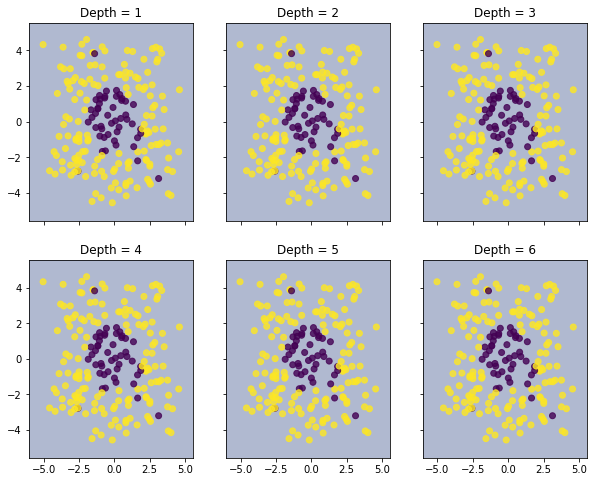

In [216]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):
    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)

    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.ravel().tolist(), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [220]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [221]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

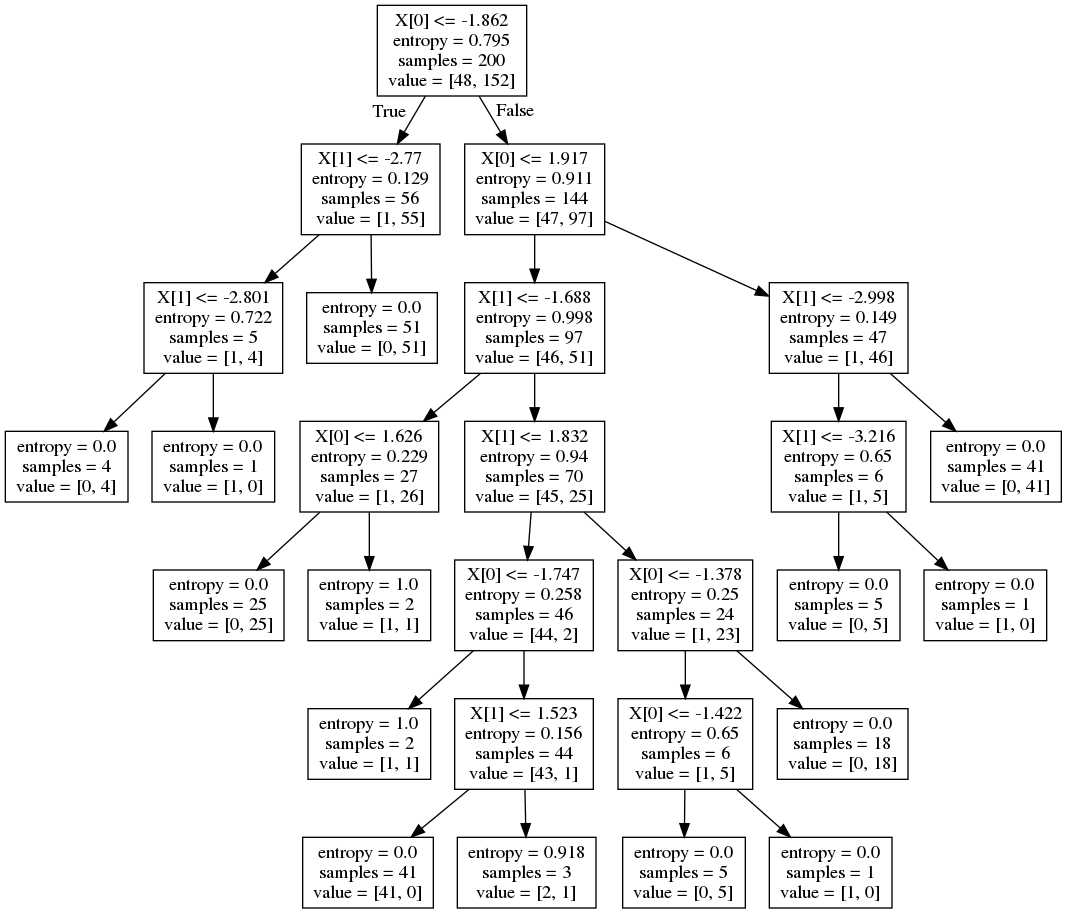

In [222]:
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [ ]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    return mae

In [ ]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

In [ ]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [ ]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [ ]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        # Your code goes here 
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        # Your code goes here

# 2-D GBM visualization - SVM data

In [ ]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization - KRR data

In [ ]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)